In [1]:
import os
import struct
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import pydot
import pydotplus
import graphviz
import scipy
import scipy.stats as sts
from scipy.stats import norm
import numpy.random as nrnd
from sklearn import metrics
from keras import regularizers
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

Using TensorFlow backend.


## Reproducibility

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Model-building function

    The model is a MLP (Not My Little Pony, Multi-Layer Perceptron)

In [3]:
def build_model(input_neurons):
    model = Sequential()
    model.add(Dense(32, input_dim=input_neurons, name="Input_dense_layer", activation="sigmoid"))
    model.add(BatchNormalization())
    model.add(Dense(16, name="Second_hidden_layer", activation="sigmoid"))
    model.add(BatchNormalization())
    model.add(Dense(1, name="Output_layer", activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=['accuracy'])
    return model

## Network metrics

In [4]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')

In [5]:
def plot_model_roc(train_labs, train_preds, test_labs, test_preds):
    "Plot roc graph from given labels and predictions"
    plt.plot(
    *roc_curve(train_labs, train_preds)[:2],
    label="Training ROC curve (area = %0.6f)" % roc_auc_score(train_labs, train_preds))
    plt.plot([0,1], [0,1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic (ROC)", fontsize=15)
    plt.legend(loc="lower right")

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_model_prc(training_labels, training_prediction, testing_labels,
             testing_prediction):
    """Plot Precision-Recall curve."""
    
    plt.plot(
        *precision_recall_curve(training_labels, training_prediction)[:2],
        label='Training average precision = %0.6f' % average_precision_score(
            training_labels, training_prediction))

    plt.plot(
        *precision_recall_curve(testing_labels, testing_prediction)[:2],
        label='Testing average precision = %0.6f' % average_precision_score(
            testing_labels, testing_prediction))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.title('2-class Precision-Recall curve (PRC)', fontsize=15)

In [7]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.6f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def plot_summary_statistics(model, history, training, testing, training_labels, testing_labels):
    # We print a summary of the progress
    training_prediction = model.predict_proba(training)
    testing_prediction = model.predict_proba(testing)

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 4, 1)
    plot_history_graph(history, 'acc', 'accuracy')
    plt.subplot(2, 4, 2)
    plot_history_graph(history, 'loss', 'loss')
    plt.subplot(2, 4, 3)
    plot_model_roc(training_labels, training_prediction, testing_labels,
                   testing_prediction)
    plt.subplot(2, 4, 4)
    plot_model_prc(training_labels, training_prediction, testing_labels,
                   testing_prediction)
    plt.subplot(2, 4, 5)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(training_labels, training_prediction.round())

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        title='Training Confusion matrix, without normalization')
    plt.subplot(2, 4, 6)
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        normalize=True,
        title='Training Confusion matrix normalized')
    plt.subplot(2, 4, 7)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(testing_labels, testing_prediction.round())

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        title='Testing Confusion matrix, without normalization')
    plt.subplot(2, 4, 8)
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        normalize=True,
        title='Testing Confusion matrix normalized')
    plt.show()

## Reading csv files

In [9]:
path_classes = "/home/tore/venv/homes.di.unimi.it/classes/GM12878.csv"
path_epigenomic = "/home/tore/venv/homes.di.unimi.it/epigenomic-data/GM12878.csv"
path_sequences = "/home/tore/venv/homes.di.unimi.it/sequences/GM12878.csv"

classes = pd.read_csv(path_classes, names = ["Titles"])
epigenomic = pd.read_csv(path_epigenomic, sep=",")

In [10]:
data = (classes.join(epigenomic))
data = data.drop("Unnamed: 0", axis=1)

In [11]:
data = data[(data["Titles"] == "A-P") | (data["Titles"] == "I-P")]

In [12]:
ap, ip = data[data["Titles"] == "A-P"], data[data["Titles"] == "I-P"]
len(ap), len(ip)

(10816, 73891)

## Creating Training and Testing Sets

    Since I-Ps are seven times more circa than A-Ps, a more fair way to use datas is needed.
    Ideas:
        > Under-sampling
        > Keeping training ratio 7:1
        > Ratio 3:1
        
    Use numpy to convert each row of the frame in a np.array
    
    Dataframe hase shape (10816, 102) so, concerning the structure of the network:
        > 101 input neurons for the 0-column holds the labels
        > 1 output neuron
        
### Under-sampling attempt

In [13]:
ip_under = (shuffle(ip))[:len(ap)]

In [14]:
ap_arr, ip_arr = ap.values, ip_under.values

    A-Ps and I-Ps should now be cropped together in order to have the full training and testing set

In [15]:
x_ip, y_ip = ip_under.values[:, ip_under.columns != "Titles"], ip_under.values[:, ip_under.columns == "Titles"]
x_ap, y_ap = ap.values[:, ap.columns != "Titles"], ap.values[:, ap.columns == "Titles"]

In [16]:
x_set, y_set = np.concatenate((x_ap, x_ip)), np.concatenate((y_ap, y_ip))

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x_set,
    y_set,
    test_size=0.3,
    random_state=42,
    shuffle=True)

In [18]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15142, 101), (6490, 101), (15142, 1), (6490, 1))

### Normalizing the dataset

In [19]:
#scaler = StandardScaler().fit(x_train)

In [20]:
norm_train, norm_test = x_train, x_test
#scaler.transform(x_train), scaler.transform(x_test)

In [21]:
def apip_sub(nparr):
    nparr = np.where(nparr == "A-P", 1, nparr)
    nparr = np.where(nparr == "I-P", 0, nparr)
    return nparr

In [22]:
y_train, y_test = apip_sub(y_train), apip_sub(y_test)
y_train, y_test

(array([[1],
        [0],
        [1],
        ...,
        [1],
        [1],
        [0]], dtype=object), array([[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [1]], dtype=object))

In [23]:
model = build_model(x_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 32)                3264      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
Second_hidden_layer (Dense)  (None, 16)                528       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 17        
Total params: 4,001
Trainable params: 3,905
Non-trainable params: 96
_________________________________________________________________


In [24]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

In [25]:
history = model.fit(
    norm_train,
    y_train,
    epochs=300,
    shuffle=True,
    batch_size=4096,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(norm_test, y_test))

In [26]:
train_preds = model.predict_proba(norm_train)
test_preds = model.predict_proba(norm_test)

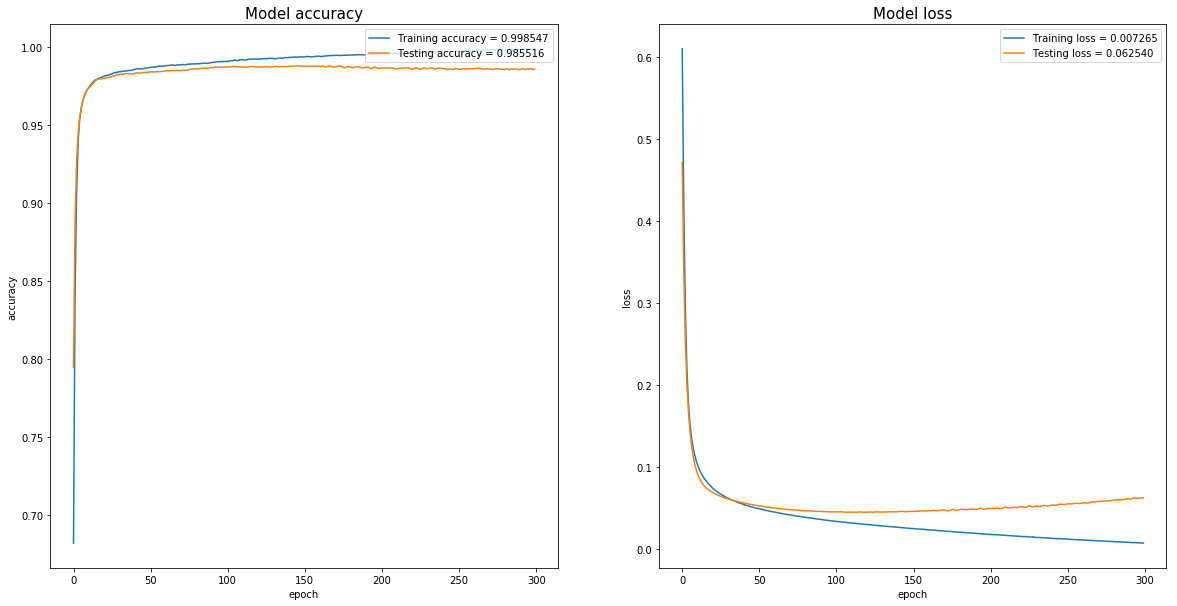

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot_history_graph(history, "acc", "accuracy")
plt.subplot(1,2,2)
plot_history_graph(history, "loss", "loss")
plt.show()

## 7:1 Ratio attempt

In [28]:
ap_arr_2, ip_arr_2 = ap.values, ip.values

In [29]:
x_ip_2, y_ip_2 = ip.values[:, ip.columns != "Titles"], ip.values[:, ip.columns == "Titles"]
x_ap_2, y_ap_2 = ap.values[:, ap.columns != "Titles"], ap.values[:, ap.columns == "Titles"]

In [30]:
x_set_2, y_set_2 = np.concatenate((x_ap_2, x_ip_2)), np.concatenate((y_ap_2, y_ip_2))

In [31]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(
    x_set_2, 
    y_set_2, 
    test_size=0.3,
    random_state=42,
    shuffle=True)

### Normalizing the dataset

In [32]:
#scaler_2 = StandardScaler().fit(x_train_2)

In [33]:
norm_train_2, norm_test_2 = x_train_2, x_test_2

In [34]:
#scaler.transform(x_train_2), scaler.transform(x_test_2)

In [35]:
y_train_2, y_test_2 = apip_sub(y_train_2), apip_sub(y_test_2)
y_train_2, y_test_2

(array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]], dtype=object), array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=object))

In [36]:
model_2 = build_model(x_train_2.shape[1])
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 32)                3264      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
Second_hidden_layer (Dense)  (None, 16)                528       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 17        
Total params: 4,001
Trainable params: 3,905
Non-trainable params: 96
_________________________________________________________________


In [37]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

In [38]:
history_2 = model_2.fit(
    norm_train_2,
    y_train_2,
    epochs=300,
    shuffle=True,
    batch_size=4096,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(norm_test_2, y_test_2))

In [39]:
train_preds_2 = model.predict_proba(norm_train_2)
test_preds_2 = model.predict_proba(norm_test_2)

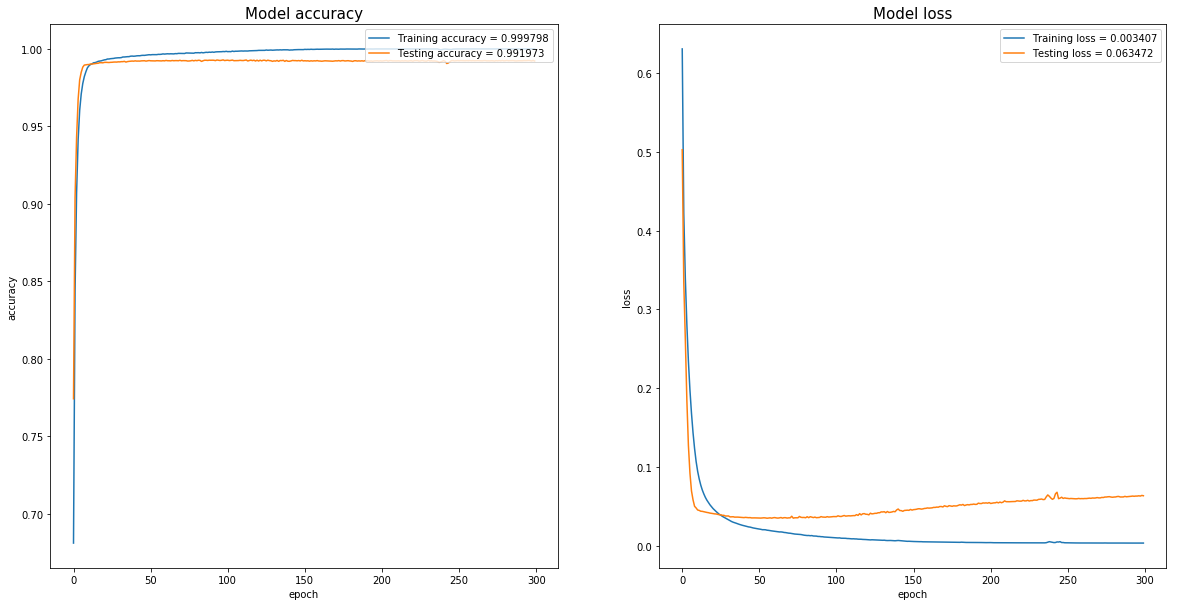

In [40]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot_history_graph(history_2, "acc", "accuracy")
plt.subplot(1,2,2)
plot_history_graph(history_2, "loss", "loss")
plt.show()